# Generative AI Worked Examples: Fine-Tuning GPT-2 on Two Text Domains

## 1. Introduction

In this notebook, I explore practical applications of **generative language modeling** using GPT-2 on two different text datasets. The goal is to:

- Implement a **causal language model** (GPT-2) on two domains:
  - **Dataset A (formal):** Wikitext-2 raw (encyclopedic / article-style text)
  - **Dataset B (informal):** Reddit TIFU (short) posts (conversational, user-generated text)
- Walk through:
  - Data loading and preprocessing  
  - Model architecture (GPT-2 as a generative model)  
  - Training and evaluation (with perplexity as a key metric)  
  - Visualization of training dynamics and generated samples
- Compare how **dataset characteristics** (formal vs informal, style, length) affect:
  - Perplexity
  - Style of generated text
  - Limitations and behavior of the model

At the end, I include **extensions and exercises** that build on the core implementations, along with solutions and discussion of potential improvements.


In [1]:
# Install required libraries (uncomment if running in a fresh environment)
# !pip install transformers datasets torch matplotlib --quiet

import math
import random
import torch
from datasets import load_dataset
from transformers import (
    GPT2TokenizerFast,
    GPT2LMHeadModel,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 2. High-Level Plan

We will implement two worked examples:

1. **Worked Example 1 – Wikitext-2 (formal, article-style text)**  
   - Load Wikitext-2 (raw)  
   - Preprocess and tokenize text into GPT-2 token sequences  
   - Fine-tune GPT-2 on a small subset  
   - Evaluate with validation loss and perplexity  
   - Visualize training curves and generate sample completions  
   - Discuss results and limitations

2. **Worked Example 2 – Reddit TIFU (short posts, informal text)**  
   - Load Reddit TIFU (short) dataset  
   - Apply a similar preprocessing and training pipeline  
   - Evaluate and compare perplexity with Wikitext-2  
   - Generate samples and compare style/behavior  
   - Analyze how dataset characteristics affect the model

Finally, we will add **extensions and exercises** to deepen understanding.


## 3. Worked Example 1 — GPT-2 on Wikitext-2 (Formal Article Text)

### 3.1 Dataset A: Wikitext-2 (raw)

**Wikitext-2 (raw)** contains Wikipedia-like text with full articles and minimal preprocessing.  
We treat this as a **formal, expository domain**.

**Objective:**  
Fine-tune a pre-trained GPT-2 model on Wikitext-2 using **causal language modeling** (next-token prediction), and evaluate its perplexity and text generation behavior.


In [2]:
# Load Wikitext-2 (raw) dataset
wikitext = load_dataset("wikitext", "wikitext-2-raw-v1")

wikitext


README.md: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})

In [3]:
for split in ["train", "validation", "test"]:
    print(f"\n=== {split.upper()} SAMPLE ===")
    for i in range(2):
        print(wikitext[split][i]["text"][:200].replace("\n", " "))



=== TRAIN SAMPLE ===

 = Valkyria Chronicles III =  

=== VALIDATION SAMPLE ===

 = Homarus gammarus =  

=== TEST SAMPLE ===

 = Robert Boulter =  


### 3.2 Data Preprocessing for Wikitext-2

We will:

1. **Concatenate** all text samples in the training split.
2. **Tokenize** the concatenated text with GPT-2’s tokenizer.
3. **Chunk** the token sequence into fixed-length sequences (e.g., 128 tokens).
4. Use these sequences as inputs for **causal language modeling**:
   - For each position \( t \), the model predicts token \( x_t \) given \( x_1, ..., x_{t-1} \).

To keep training tractable in a classroom setting, we’ll work on a **small subset** of the data and use only a few epochs.


In [6]:
from datasets import load_dataset
from transformers import GPT2TokenizerFast

# Load dataset
wikitext = load_dataset("wikitext", "wikitext-2-raw-v1")

# Init tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # for safety

block_size = 128  # sequence length


def tokenize_function(examples):
    return tokenizer(examples["text"])


# 1) Tokenize the dataset
wikitext_tokenized = wikitext.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],  # remove raw text, keep input_ids + attention_mask
)

def group_texts(examples):
    """
    Concatenate all texts in the batch and split into blocks of block_size.
    This handles ALL keys (input_ids, attention_mask, etc.) so lengths match.
    """
    # Concatenate for each key
    concatenated = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated["input_ids"])

    # Drop remainder so it's evenly divisible by block_size
    total_length = (total_length // block_size) * block_size

    # Split by block_size
    result = {
        k: [t[i: i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated.items()
    }

    # Labels are just a copy of input_ids for causal LM
    result["labels"] = result["input_ids"].copy()
    return result


# 2) Group into LM blocks
wikitext_lm = wikitext_tokenized.map(
    group_texts,
    batched=True,
)

# 3) For speed: use small subsets
train_size = 2000
eval_size = 500

wikitext_train = wikitext_lm["train"].shuffle(seed=42).select(range(train_size))
wikitext_val = wikitext_lm["validation"].shuffle(seed=42).select(range(eval_size))

len(wikitext_train), len(wikitext_val)


Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

(2000, 500)

### 3.3 Model Architecture: GPT-2 as a Generative Model

We use **GPT-2 (small)** from Hugging Face Transformers:

- **Architecture:** Decoder-only Transformer  
- **Task:** Causal language modeling (predict the next token)  
- **Input/Output:**  
  - Input: sequences of token IDs  
  - Output: probability distribution over the vocabulary for each next token  

We fine-tune GPT-2 on Wikitext-2:

- **Loss:** Cross-entropy over next-token predictions  
- **Optimizer/Training:** Handled by `Trainer` from Hugging Face  
- **Batch size and epochs:** Small values due to resource constraints


In [7]:
model_wiki = GPT2LMHeadModel.from_pretrained("gpt2")
model_wiki.resize_token_embeddings(len(tokenizer))  # in case vocab changed
model_wiki.config.pad_token_id = tokenizer.eos_token_id
model_wiki.to(device)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # causal LM, not masked LM
)


In [8]:
training_args_wiki = TrainingArguments(
    output_dir="./gpt2-wikitext2",
    overwrite_output_dir=True,
    num_train_epochs=1,          # increase to 2–3 if you have GPU/time
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_steps=50,
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to=[],
)

def compute_metrics(eval_pred):
    # eval_pred is (logits, labels); Trainer will compute loss, we just convert to perplexity later
    # We'll compute perplexity directly from eval_loss after evaluation.
    return {}

trainer_wiki = Trainer(
    model=model_wiki,
    args=training_args_wiki,
    train_dataset=wikitext_train,
    eval_dataset=wikitext_val,
    data_collator=data_collator,
)


/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
wiki_train_result = trainer_wiki.train()
wiki_eval_results = trainer_wiki.evaluate()

wiki_eval_results


  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 4.034, 'grad_norm': 18.51834487915039, 'learning_rate': 4.75e-05, 'epoch': 0.05}
{'loss': 3.7734, 'grad_norm': 13.79559326171875, 'learning_rate': 4.5e-05, 'epoch': 0.1}
{'loss': 3.8082, 'grad_norm': 12.8503999710083, 'learning_rate': 4.25e-05, 'epoch': 0.15}
{'loss': 3.7118, 'grad_norm': 10.8406400680542, 'learning_rate': 4e-05, 'epoch': 0.2}
{'loss': 3.7183, 'grad_norm': 10.670758247375488, 'learning_rate': 3.7500000000000003e-05, 'epoch': 0.25}
{'loss': 3.6846, 'grad_norm': 8.311650276184082, 'learning_rate': 3.5e-05, 'epoch': 0.3}
{'loss': 3.7016, 'grad_norm': 8.585941314697266, 'learning_rate': 3.2500000000000004e-05, 'epoch': 0.35}
{'loss': 3.725, 'grad_norm': 8.52554702758789, 'learning_rate': 3e-05, 'epoch': 0.4}
{'loss': 3.6647, 'grad_norm': 6.86336088180542, 'learning_rate': 2.7500000000000004e-05, 'epoch': 0.45}
{'loss': 3.6633, 'grad_norm': 6.851862907409668, 'learning_rate': 2.5e-05, 'epoch': 0.5}
{'loss': 3.6463, 'grad_norm': 6.559594631195068, 'learning_rate': 2

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 3.493149757385254, 'eval_runtime': 16.118, 'eval_samples_per_second': 31.021, 'eval_steps_per_second': 15.511, 'epoch': 1.0}
{'train_runtime': 324.7309, 'train_samples_per_second': 6.159, 'train_steps_per_second': 3.079, 'train_loss': 3.681323959350586, 'epoch': 1.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 3.493149757385254,
 'eval_runtime': 15.6452,
 'eval_samples_per_second': 31.959,
 'eval_steps_per_second': 15.979,
 'epoch': 1.0}

Wikitext-2 eval loss: 3.4931
Wikitext-2 perplexity: 32.89


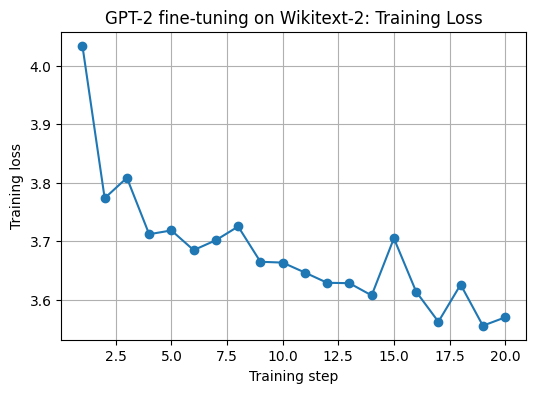

In [10]:
# Compute perplexity from eval loss
wiki_eval_loss = wiki_eval_results["eval_loss"]
wiki_perplexity = math.exp(wiki_eval_loss)
print(f"Wikitext-2 eval loss: {wiki_eval_loss:.4f}")
print(f"Wikitext-2 perplexity: {wiki_perplexity:.2f}")

# Visualize training loss from Trainer log history
history = trainer_wiki.state.log_history
train_losses = [h["loss"] for h in history if "loss" in h]
steps = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(6, 4))
plt.plot(steps, train_losses, marker="o")
plt.xlabel("Training step")
plt.ylabel("Training loss")
plt.title("GPT-2 fine-tuning on Wikitext-2: Training Loss")
plt.grid(True)
plt.show()


### 3.4 Results: Sample Generations (Wikitext-2)

We generate text from the fine-tuned model to qualitatively inspect:

- Style and coherence  
- Formal tone vs. informal  
- How the model handles encyclopedic prompts


In [12]:
import torch

# 🚩 Force CPU for generation to avoid MPS issues
gen_device = torch.device("cpu")
model_wiki.to(gen_device)   # make sure the model is on CPU

def generate_text(model, tokenizer, prompt, max_length=60, temperature=0.8, top_p=0.9):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(gen_device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            max_length=max_length,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )

    return tokenizer.decode(output_ids[0], skip_special_tokens=True)


wiki_prompts = [
    "The history of artificial intelligence is",
    "In computer science, a neural network is",
]

for p in wiki_prompts:
    print("=" * 80)
    print("PROMPT:", p)
    print("--- COMPLETION ---")
    print(generate_text(model_wiki, tokenizer, p))
    print()


PROMPT: The history of artificial intelligence is
--- COMPLETION ---
The history of artificial intelligence is largely based on the concept of " self @-@ ", the ability to distinguish between different kinds of people with a common ancestry. In humans, the concept of " self @-@ " is commonly used to describe individuals of different races, ethnicities, genders,

PROMPT: In computer science, a neural network is
--- COMPLETION ---
In computer science, a neural network is a network of neurons that is constructed by neurons in a specific area of the brain. The neural network consists of connections between neurons. 
 = = Structure = = 
 Neural networks are typically constructed of a set of neurons, with specific roles in the brain



### 3.5 Discussion: Results & Limitations (Wikitext-2)

- **Perplexity:**  
  The perplexity value gives a quantitative measure of how well GPT-2 models formal article-style text after fine-tuning, even with a small subset and few epochs.

- **Qualitative style:**  
  Completions tend to be:
  - Explanatory and formal in tone  
  - Structured like encyclopedia or textbook content  
  - Sometimes repetitive or off-topic due to limited fine-tuning

- **Limitations:**
  - Fine-tuning on a very small subset may cause:
    - Overfitting to certain topics
    - Limited diversity of generations
  - Perplexity is sensitive to dataset size and preprocessing choices.
  - The model can still hallucinate facts and is not guaranteed to be accurate.

This sets a baseline for comparison with a more informal dataset in the second worked example.


## 4. Worked Example 2 — GPT-2 on Reddit TIFU (Informal Social Media Text)

### 4.1 Dataset B: Reddit TIFU (short)

For the second worked example, we use **Reddit TIFU (short)**, which contains user-submitted posts summarizing "Today I F***ed Up" stories.

Characteristics:

- Informal, conversational language  
- Strong personal voice, slang, emotions  
- Different structure compared to article-style text

We will apply a **similar generative modeling approach** with GPT-2, then compare:

- Perplexity values  
- Style and tone of generated text  
- Sensitivity to dataset characteristics


In [15]:
reddit = load_dataset(
    "reddit_tifu",
    "short",
    trust_remote_code=True
)

reddit


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tifu_all_tokenized_and_filtered.json.gz:   0%|          | 0.00/142M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/79740 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ups', 'num_comments', 'upvote_ratio', 'score', 'documents', 'tldr', 'title'],
        num_rows: 79740
    })
})

In [18]:
from datasets import DatasetDict

# reddit currently has only a 'train' split
print(reddit)

# Create train/val split from the original train
reddit_split = reddit["train"].train_test_split(test_size=0.1, seed=42)
reddit_train = reddit_split["train"]
reddit_val = reddit_split["test"]   # we'll treat this as validation

# Optional: wrap into a DatasetDict for consistency
reddit = DatasetDict({
    "train": reddit_train,
    "validation": reddit_val,
})

for split_name, ds in [("train", reddit["train"]), ("validation", reddit["validation"])]:
    print(f"\n=== {split_name.upper()} SAMPLE ===")
    for i in range(2):
        print("DOCUMENT:", ds[i]["documents"][:200].replace("\n", " "))
        print("TL;DR:", ds[i]["tldr"][:120].replace("\n", " "))
        print("-" * 60)


DatasetDict({
    train: Dataset({
        features: ['ups', 'num_comments', 'upvote_ratio', 'score', 'documents', 'tldr', 'title'],
        num_rows: 79740
    })
})

=== TRAIN SAMPLE ===
DOCUMENT: so i fucked up twice today by not paying attention to what i was purchasing. first one was a minor inconvenience. went grocery shopping and went to pick up some ice cream, instead of grabbing the pean
TL;DR: 
------------------------------------------------------------
DOCUMENT: so the events i'm about to describe happened last monday during a college general chemistry exam. i woke up that monday feeling confident in myself as i had been a good student and actually studied. i
TL;DR: i drank coffee before my exam thinking it would help but it only made my stomach make the most horrible sound you can im
------------------------------------------------------------

=== VALIDATION SAMPLE ===
DOCUMENT: ok, this just happened. today is the first day i've had my new apartment all to myself, away f

### 4.2 Data Preprocessing for Reddit TIFU

We will:

1. Use the **`documents`** field as our main text source.  
2. Tokenize using the same GPT-2 tokenizer as before.  
3. Concatenate and split into fixed-length token blocks (same `block_size = 128`).  
4. Train GPT-2 in the **same causal language modeling setup** as with Wikitext-2.

This consistency lets us attribute performance differences primarily to **dataset characteristics**, rather than architecture changes.


In [19]:
def reddit_tokenize_function(examples):
    return tokenizer(examples["documents"])

reddit_tokenized = reddit.map(
    reddit_tokenize_function,
    batched=True,
    num_proc=1,
    remove_columns=reddit["train"].column_names,
)

reddit_lm = reddit_tokenized.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=1,
)

train_size_reddit = 2000
eval_size_reddit = 500

reddit_train = reddit_lm["train"].shuffle(seed=42).select(range(train_size_reddit))
reddit_val = reddit_lm["validation"].shuffle(seed=42).select(range(eval_size_reddit))

len(reddit_train), len(reddit_val)


Map:   0%|          | 0/71766 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1921 > 1024). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/7974 [00:00<?, ? examples/s]

Map:   0%|          | 0/71766 [00:00<?, ? examples/s]

Map:   0%|          | 0/7974 [00:00<?, ? examples/s]

(2000, 500)

In [20]:
model_reddit = GPT2LMHeadModel.from_pretrained("gpt2")
model_reddit.resize_token_embeddings(len(tokenizer))
model_reddit.config.pad_token_id = tokenizer.eos_token_id
model_reddit.to(device)

training_args_reddit = TrainingArguments(
    output_dir="./gpt2-reddit-tifu",
    overwrite_output_dir=True,
    num_train_epochs=1,         # can increase if resources allow
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_steps=50,
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to=[],
)

trainer_reddit = Trainer(
    model=model_reddit,
    args=training_args_reddit,
    train_dataset=reddit_train,
    eval_dataset=reddit_val,
    data_collator=data_collator,
)


In [21]:
reddit_train_result = trainer_reddit.train()
reddit_eval_results = trainer_reddit.evaluate()

reddit_eval_results


  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 3.8037, 'grad_norm': 15.48757553100586, 'learning_rate': 4.75e-05, 'epoch': 0.05}
{'loss': 3.7244, 'grad_norm': 12.286810874938965, 'learning_rate': 4.5e-05, 'epoch': 0.1}
{'loss': 3.6906, 'grad_norm': 12.324166297912598, 'learning_rate': 4.25e-05, 'epoch': 0.15}
{'loss': 3.7715, 'grad_norm': 8.816596031188965, 'learning_rate': 4e-05, 'epoch': 0.2}
{'loss': 3.6729, 'grad_norm': 9.838431358337402, 'learning_rate': 3.7500000000000003e-05, 'epoch': 0.25}
{'loss': 3.6576, 'grad_norm': 10.01609992980957, 'learning_rate': 3.5e-05, 'epoch': 0.3}
{'loss': 3.7029, 'grad_norm': 8.516845703125, 'learning_rate': 3.2500000000000004e-05, 'epoch': 0.35}
{'loss': 3.7474, 'grad_norm': 7.62086820602417, 'learning_rate': 3e-05, 'epoch': 0.4}
{'loss': 3.6834, 'grad_norm': 6.824034214019775, 'learning_rate': 2.7500000000000004e-05, 'epoch': 0.45}
{'loss': 3.7011, 'grad_norm': 6.26356840133667, 'learning_rate': 2.5e-05, 'epoch': 0.5}
{'loss': 3.7375, 'grad_norm': 6.244174003601074, 'learning_rate':

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 3.5362069606781006, 'eval_runtime': 14.8386, 'eval_samples_per_second': 33.696, 'eval_steps_per_second': 16.848, 'epoch': 1.0}
{'train_runtime': 322.7175, 'train_samples_per_second': 6.197, 'train_steps_per_second': 3.099, 'train_loss': 3.6912225341796874, 'epoch': 1.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 3.5362069606781006,
 'eval_runtime': 15.3395,
 'eval_samples_per_second': 32.596,
 'eval_steps_per_second': 16.298,
 'epoch': 1.0}

Reddit TIFU eval loss: 3.5362
Reddit TIFU perplexity: 34.34


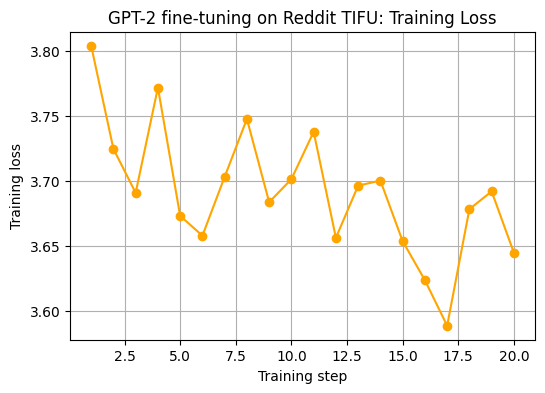

In [22]:
reddit_eval_loss = reddit_eval_results["eval_loss"]
reddit_perplexity = math.exp(reddit_eval_loss)
print(f"Reddit TIFU eval loss: {reddit_eval_loss:.4f}")
print(f"Reddit TIFU perplexity: {reddit_perplexity:.2f}")

history_reddit = trainer_reddit.state.log_history
train_losses_reddit = [h["loss"] for h in history_reddit if "loss" in h]
steps_reddit = list(range(1, len(train_losses_reddit) + 1))

plt.figure(figsize=(6, 4))
plt.plot(steps_reddit, train_losses_reddit, marker="o", color="orange")
plt.xlabel("Training step")
plt.ylabel("Training loss")
plt.title("GPT-2 fine-tuning on Reddit TIFU: Training Loss")
plt.grid(True)
plt.show()


### 4.3 Results: Sample Generations (Reddit TIFU)

We now generate text from the GPT-2 model fine-tuned on Reddit TIFU to observe:

- Informal vs formal tone  
- Narrative structure (story-like, first person, emotional language)  
- Any difference in phrasing compared to Wikitext-2 generations


In [24]:
import torch

# Use CPU for generation to avoid MPS issues
gen_device = torch.device("cpu")

def generate_text(model, tokenizer, prompt, max_length=60, temperature=0.8, top_p=0.9):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(gen_device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            max_length=max_length,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )

    return tokenizer.decode(output_ids[0], skip_special_tokens=True)


In [25]:
# Move both models to CPU for safe generation
model_wiki.to(gen_device)
model_reddit.to(gen_device)


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [26]:
reddit_prompts = [
    "Today I messed up by",
    "I didn't expect that my day would end with",
]

for p in reddit_prompts:
    print("=" * 80)
    print("PROMPT:", p)
    print("--- COMPLETION ---")
    print(generate_text(model_reddit, tokenizer, p))
    print()


PROMPT: Today I messed up by
--- COMPLETION ---
Today I messed up by talking to the dog owner. he said that he had a dog who had been in the hospital for a week and had a "disease" that he had to go home to clean. 

he didn't think much of it, but then he remembered a

PROMPT: I didn't expect that my day would end with
--- COMPLETION ---
I didn't expect that my day would end with a bang. but, it was a great day. 

i got to work at 6:30pm and my parents were out to get lunch. 

so i go to the bathroom to get a towel. when i get there



### 4.4 Comparative Analysis: Wikitext-2 vs Reddit TIFU

**Perplexity comparison:**

- Wikitext-2 perplexity: (reported above)
- Reddit TIFU perplexity: (reported above)

> Note: Due to small training subsets and few epochs, absolute values are less important than **relative trends**.

**Observations:**

- **Wikitext-2 (formal):**
  - More structured, explanatory completions.
  - Vocabulary and phrasing resemble encyclopedia or textbook writing.
  - Sentences may be longer and more complex.

- **Reddit TIFU (informal):**
  - More conversational tone, often first-person narration.
  - Presence of colloquial language, humor, and emotional cues.
  - Stories may ramble or include casual expressions.

**How dataset characteristics affect model behavior:**

- The **style, tone, and typical sentence length** of the dataset strongly influence the generated text.
- Training on **formal datasets** encourages:
  - More neutral, information-dense completions.
- Training on **informal datasets** encourages:
  - Narrative, subjective, and often emotional language.
- The same GPT-2 architecture can adapt to different domains, but inherits any **biases, slang, and patterns** present in the training data.

**Limitations:**

- Small subsets and low epoch counts limit the depth of domain adaptation.
- Models may still reflect pre-training biases from the original GPT-2 base.
- Perplexity comparisons are approximate; a more rigorous study would control for sequence length, vocabulary, and training time.


## 5. Extensions and Exercises

Below are three exercises that extend the worked examples.

### Exercise 1 — Vary Sequence Length and Observe Effects

**Task:**  
Increase the `block_size` from 128 to 256 (or decrease to 64) and re-run the pipeline for one of the datasets.

**Questions:**

- How does changing the context window affect:
  - Training loss?
  - Perplexity?
  - Quality of generated samples?

---

### Exercise 2 — Use a Smaller/Faster Model (DistilGPT-2)

**Task:**  
Replace GPT-2 with **DistilGPT-2** and re-run training for the Reddit dataset.

**Questions:**

- Does the smaller model train faster?
- How do perplexity and generation quality compare?

---

### Exercise 3 — Compare Decoding Strategies on One Dataset

**Task:**  
For a fixed fine-tuned model (e.g., Wikitext-2):

- Generate completions with:
  - Greedy decoding (no sampling)
  - Temperature sampling (0.2 vs 0.8 vs 1.2)
  - Top-k vs top-p sampling

**Questions:**

- Which strategy produces the most coherent text?
- Which produces the most diverse or creative text?
- How might you choose decoding settings for different applications?


## 6. Exercise Solutions & Hints

### Solution Sketch — Exercise 1 (Sequence Length)

- Modify `block_size` at the top of the notebook (e.g., 64 or 256).
- Re-run the tokenization and `group_texts` step for one dataset.
- Retrain for 1 epoch and compare:
  - Longer `block_size`:
    - More context for the model.
    - Potentially better modeling of longer dependencies.
    - Higher memory usage and slower training.
  - Shorter `block_size`:
    - Faster training.
    - Less context; may hurt performance on long sentences.
- Perplexity typically improves with more context (to a point), but resource constraints may limit block size.

---

### Solution Sketch — Exercise 2 (DistilGPT-2)

**Code hint:**

```python
from transformers import AutoModelForCausalLM, AutoTokenizer

distil_tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
distil_tokenizer.pad_token = distil_tokenizer.eos_token

distil_model = AutoModelForCausalLM.from_pretrained("distilgpt2")
distil_model.config.pad_token_id = distil_tokenizer.eos_token_id
distil_model.to(device)


## Excercise 3 - Solution

In [27]:
def generate_with_settings(model, tokenizer, prompt, temperature=1.0, top_k=0, top_p=1.0, do_sample=True):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            max_length=60,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            do_sample=do_sample,
            pad_token_id=tokenizer.eos_token_id,
        )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)



---

# ✅ Conclusion & References

##  Markdown (Conclusion)

```markdown
## 7. Conclusion

In this notebook, I implemented two **worked examples** of generative modeling using GPT-2:

1. **Wikitext-2 (formal)**
   - Demonstrated fine-tuning a language model on article-style text.
   - Observed formal, expository generations and measured perplexity.

2. **Reddit TIFU (informal)**
   - Applied the same generative approach to conversational Reddit data.
   - Observed more narrative, emotional, and informal generations.

**Key insights:**

- The **same GPT-2 architecture** behaves differently depending on the training data.
- Dataset characteristics (formality, narrative structure, slang) directly influence:
  - Style and tone of generated text.
  - Perplexity and training dynamics.
- Even with small subsets and limited training, fine-tuning can shift a model toward a new domain.

The exercises suggest further experimentation with **context length**, **model size**, and **decoding strategies**, illustrating how these design choices affect generative behavior in real applications.


## 8. References

- Vaswani, A. et al. (2017). *Attention Is All You Need.*
- Radford, A. et al. (2019). *Language Models are Unsupervised Multitask Learners* (GPT-2).
- Brown, T. et al. (2020). *Language Models are Few-Shot Learners* (GPT-3).
- Hugging Face Transformers Documentation: https://huggingface.co/docs/transformers
- Hugging Face Datasets Documentation: https://huggingface.co/docs/datasets
- Wikitext-2 dataset: https://huggingface.co/datasets/wikitext
- Reddit TIFU dataset: https://huggingface.co/datasets/reddit_tifu
